# Data

The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (1/0) to a term deposit (variable y). The dataset can be downloaded from here.

Source: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from pylab import *
%matplotlib inline
import numpy as np

Using TensorFlow backend.


In [2]:
data=pd.read_csv('banking.csv')

# 1.Get some insights from data

## Explore numeric features

In [3]:
data.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


### From the description of data, we can discover that:
#### a. the average number of contacts in this campaign is 2.57;
#### b. most of clients contacted in this campaign weren't contacted by the previous campaigns;
#### c. most people didn't subscribe to a term deposit and only 11.27% of them subscibed a term deposit. 

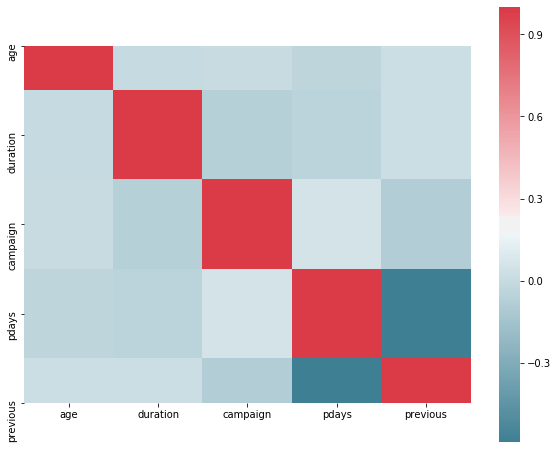

In [4]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data[['age','duration','campaign','pdays','previous']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### From the correlation perspective, numeric features don't have a strong correlation.

## Explore categories

In [5]:
# The list of potential features
list_p_f=[]
for i in data.select_dtypes(include='object').columns:
    mean_difference=data.groupby(i)['y'].mean().max()
    if mean_difference>=0.20:
        list_p_f.append(i)
        print(i,round(mean_difference,2))
    else:
        pass

job 0.31
marital 0.15
education 0.22
default 0.13
housing 0.12
loan 0.11
contact 0.15
month 0.51
day_of_week 0.12
poutcome 0.65


In [6]:
# Subcategories of potential categorical features
for i in list_p_f:
    print(i,data[i].unique(),'\n')

job ['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student'] 

education ['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate'] 

month ['aug' 'nov' 'jun' 'apr' 'jul' 'may' 'oct' 'mar' 'sep' 'dec'] 

poutcome ['nonexistent' 'success' 'failure'] 



In [7]:
# Combine the subcategories with the same meaning to one subcategory
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

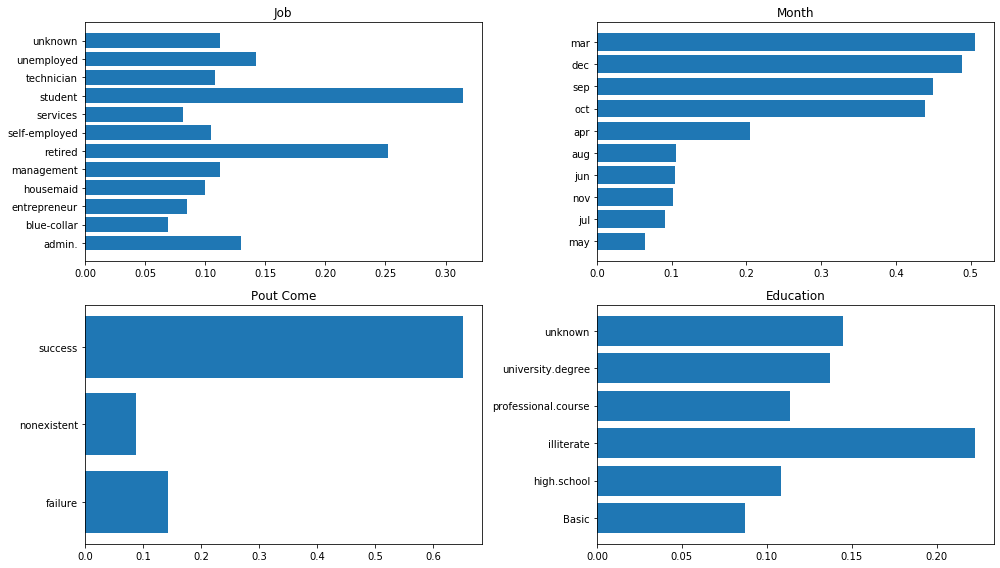

In [8]:
fig, axs = plt.subplots(2, 2,figsize=(14,8))
# job
axs[0,0].title.set_text('Job')
axs[0,0].barh(data.groupby('job')['y'].mean().keys(),data.groupby('job')['y'].mean().values)
# month
axs[0,1].title.set_text('Month')
axs[0,1].barh(data.groupby('month')['y'].mean().sort_values().keys(),data.groupby('month',sort=True)['y'].mean().sort_values().values)
# poutcome
axs[1,0].title.set_text('Pout Come')
axs[1,0].barh(data.groupby('poutcome')['y'].mean().keys(),data.groupby('poutcome')['y'].mean().values)
# education
axs[1,1].title.set_text('Education')
axs[1,1].barh(data.groupby('education')['y'].mean().keys(),data.groupby('education')['y'].mean().values)
plt.tight_layout()

### Among the sub-categories of the four categories, including work, month, basic salary, and education level, the proportion of people with a term deposit is the largest, more than 20%. 
#### Job: Students has the highest percentage to have a term deposit in the sample, while blue-collar has the lowest percentage. 
There is an **assumption** that students have the willness and free money to do some financial management while blue-collar workers may don't have extra money to do such investment activity. **Another assumption** is that more than two-thirds of blue-collar workers have only received basic education or high school education. People who have such background prefer to not have a term desposit.
#### Month (last contact month of the year):
No obvious seasonality
#### Poutcome (the outcome of the previous marketing campaign): 
People who accepted the previous marketing campaign have a much higher probability to subscribe to a term deposit than others.
#### Education:
Illiterate people have the highest percentage to have a term deposit in the sample, while people who only accepted basic education has the lowest percentage. 

# 2. Modeling

## Preprocess data

In [9]:
# Get dummy variables of categories
for i in data.select_dtypes(include='object').columns:
    cat_list='cat'+'_'+i
    cat_list = pd.get_dummies(data[i], prefix=i)
    data1=data.join(cat_list)
    data=data1

In [10]:
# Delete the original categories
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in data.select_dtypes(include='object').columns]
data_use=data[to_keep]
data_use.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

In [11]:
y=data_use.loc[:,'y']
x=data_use.loc[:,data_use.columns!='y']
y= pd.DataFrame(data=y,columns=['y'])

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=6)

### Logistics regression

In [13]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(Y_test, y_pred)
print(confusion_matrix1)
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression classifier on test set: 0.91
[[7122  173]
 [ 584  359]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7295
           1       0.67      0.38      0.49       943

    accuracy                           0.91      8238
   macro avg       0.80      0.68      0.72      8238
weighted avg       0.90      0.91      0.90      8238



In [14]:
Y_test['y'].value_counts()

0    7295
1     943
Name: y, dtype: int64

# Summary

The accuracy of logistic regression is 91% which is 3% higher than the majority baseline. There are several challenges for this project:
1. This sample is unbalanced. Only 11% of the observations are people who subscribed, causing high false negative rate. There are 584 people who subscribed a term deposit are predicted wrongly as the non-subscribtion.

2. In the future, other models will be tried.

# Some wrong attempts

###  SMOTE
As mentioned before, the no-subscription only take 11.27% of the total. If we use the data train our model directly, there is a big probalility that all of the observations will be regarded as the "no-subscription". Thus, SMOTE can be applied in this case to balance the samples while doesn't change its distribution.

In [15]:
# Oversample data
sm = SMOTE(random_state=6)
sm_data_x,sm_data_y=sm.fit_sample(X_train, Y_train)
sm_data_x = pd.DataFrame(data=sm_data_x,columns=X_train.columns )
sm_data_y= pd.DataFrame(data=sm_data_y,columns=['y'])
sm_data_y['y'].value_counts()

/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1    29253
0    29253
Name: y, dtype: int64

### RFE

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(sm_data_x, sm_data_y.values.ravel())
use_columns=sm_data_x.columns[rfe.support_]

/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

###  Significance evaluation

In [17]:
import statsmodels.api as st
x=sm_data_x[use_columns]
y=sm_data_y['y']
logit_model=st.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.547761
         Iterations: 35
                                     Results: Logit
Model:                       Logit                   Pseudo R-squared:        0.210     
Dependent Variable:          y                       AIC:                     64134.6557
Date:                        2019-11-04 10:12        BIC:                     64314.1934
No. Observations:            58506                   Log-Likelihood:          -32047.   
Df Model:                    19                      LL-Null:                 -40553.   
Df Residuals:                58486                   LLR p-value:             0.0000    
Converged:                   0.0000                  Scale:                   1.0000    
No. Iterations:              35.0000                                                    
----------------------------------------------------------------------------------------
                               Coef.    Std.Err.     z     P>|z|     [0.025     0

/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [18]:
cols=['euribor3m', 'job_student', 'job_retired', 'marital_unknown','education_Basic','education_high.school','education_unknown',
'education_professional.course', 'education_university.degree', 'month_dec', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
x_train=sm_data_x[cols]
y_train=sm_data_y
x_test=X_test[cols]

The columns selected by RFE are consistent with the columns selected in session **Explore categories**, proving again that *job*, *education*, *month* and *poutcome* are the most influential factors to decide whether people will subscribe or not.

### Logistic regression

In [19]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
y_pred= pd.DataFrame(data=y_pred,columns=['y'])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, Y_test)))
confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)
print(classification_report(Y_test, y_pred))

/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/amanda/anaconda3/envs/azure/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression classifier on test set: 0.81
[[6013 1282]
 [ 304  639]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7295
           1       0.33      0.68      0.45       943

    accuracy                           0.81      8238
   macro avg       0.64      0.75      0.66      8238
weighted avg       0.88      0.81      0.83      8238



After applying SMOTE and RFE, the performance of logistic regression doesn't become better. However, false negative rate reduced and there is a trade off between accuracy and false negative rate